In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import os
from scipy.interpolate import UnivariateSpline

overleaf_path = '/Users/daniel/Dropbox (Sydney Uni)/Apps/Overleaf/adra/figs/'

def mnras_size(fig_width_pt, square=False):
    inches_per_pt = 1.0/72.00              # Convert pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0     # Most aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt # Figure width in inches
    if square:
        fig_height = fig_width
    else:
        fig_height = fig_width*golden_mean
    return [fig_width,fig_height]

plt.style.use('science')

In [2]:
mnras_size(240.)

[3.333333333333333, 2.060113295832983]

In [3]:
tpfs = lk.search_targetpixelfile('alpha Draconis', mission='TESS').download_all()

In [4]:
lc_files = lk.search_lightcurvefile('alpha Draconis', mission='TESS').download_all()#.SAP_FLUX

In [5]:
def fit_continuum(x, y, ivars, order=6, nsigma=[0.3,3.0], maxniter=50):
    """Fit the continuum using sigma clipping
    Args:
        x: The wavelengths
        y: The log-fluxes
        order: The polynomial order to use
        nsigma: The sigma clipping threshold: tuple (low, high)
        maxniter: The maximum number of iterations to do
    Returns:
        The value of the continuum at the wavelengths in x
    """
    A = np.vander(x - np.nanmean(x), order+1)
    m = np.ones(len(x), dtype=bool)
    for i in range(maxniter):
        m[ivars == 0] = 0  # mask out the bad pixels
        w = np.linalg.solve(np.dot(A[m].T, A[m]), np.dot(A[m].T, y[m]))
        mu = np.dot(A, w)
        resid = y - mu
        sigma = np.sqrt(np.nanmedian(resid**2))
        #m_new = np.abs(resid) < nsigma*sigma
        m_new = (resid > -nsigma[0]*sigma) & (resid < nsigma[1]*sigma)
        if m.sum() == m_new.sum():
            m = m_new
            break
        m = m_new
    return mu

In [6]:
# # data = np.arange(100, 0, -1).reshape(10, 10)
from matplotlib import patches

# fig, ax = plt.subplots(figsize=[10,10])

# tpf = tpfs[0]
# img_extent = (tpf.column - 0.5, tpf.column + tpf.shape[2] - 0.5,
#                           tpf.row - 0.5, tpf.row + tpf.shape[1] - 0.5)
# im = ax.imshow(tpfs[0].flux[0],
# #             np.log(data_to_plot.value), 
#                origin='lower', extent=img_extent, cmap='Blues', aspect='auto')

# cax = ax.inset_axes([0, 1.07, 1, 0.02])
# aperture_mask = tpf._parse_aperture_mask(tpf.pipeline_mask)
# for i in range(tpf.shape[1]):
#     for j in range(tpf.shape[2]):
#         if aperture_mask[i, j]:
#             rect = patches.Rectangle(
#                             xy=(j+tpf.column-0.5, i+tpf.row-0.5),
#                             width=1, height=1, linewidth=0.7, color='red',
#                             fill=False, 
# #                 hatch='//'
#             )
#             ax.add_patch(rect)
                        
# cbar = fig.colorbar(im, cax=cax, orientation='horizontal', 
# #                     format='%.0e'
#                    )
# cbar.set_label(label='Flux (e$^{-1}$/s)', labelpad=-50)
# cbar.ax.set_xticklabels([0., 0.2, 0.4, 0.6, 0.8, 1])
# # cbar.format('%.3f')
# # plt.show()



In [10]:
btjd = 2457000



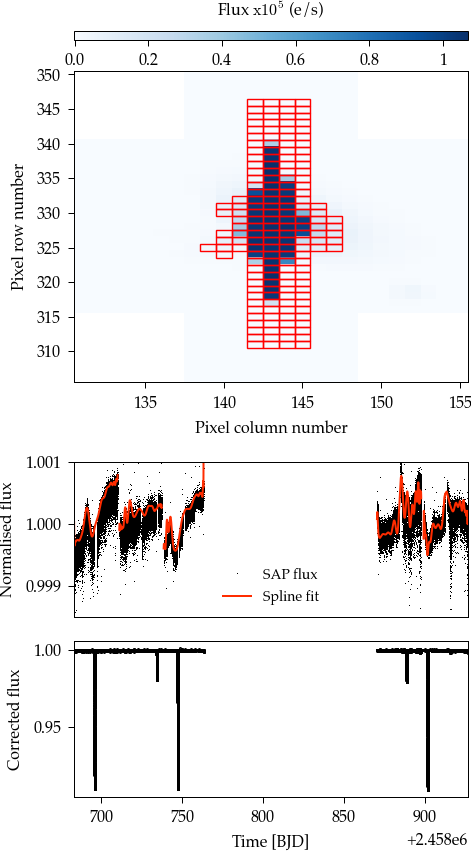

In [14]:
fig, axes = plt.subplots(3,1, figsize=[3.36,6], gridspec_kw={'height_ratios':[1,0.5,0.5]}, constrained_layout=True)

ax = axes[0]
# tpfs[0].plot(ax=ax, aperture_mask=tpfs[0].pipeline_mask, style='science', aspect='auto', 
#              mask_color='lightgrey', cmap='Blues', show_colorbar=False)
# # plt.colorbar()
# ax.set(title='')

tpf = tpfs[0]
img_extent = (tpf.column - 0.5, tpf.column + tpf.shape[2] - 0.5,
                          tpf.row - 0.5, tpf.row + tpf.shape[1] - 0.5)
im = ax.imshow(tpfs[0].flux[0],
#             np.log(data_to_plot.value), 
               origin='lower', extent=img_extent, cmap='Blues', aspect='auto')

# cax = fig.add_axes([0.8, 0.2, 0.02, 0.6])
cax = ax.inset_axes([0, 1.1, 1, 0.03])
aperture_mask = tpf._parse_aperture_mask(tpf.pipeline_mask)
for i in range(tpf.shape[1]):
    for j in range(tpf.shape[2]):
        if aperture_mask[i, j]:
            rect = patches.Rectangle(
                            xy=(j+tpf.column-0.5, i+tpf.row-0.5),
                            width=1, height=1, linewidth=0.7, color='red',
                            fill=False, 
            )
            ax.add_patch(rect)
                        
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label(label='Flux $\mathrm{x}10^5$ (e/s)', labelpad=-35)
cbar.ax.set_xticklabels([0., 0.2, 0.4, 0.6, 0.8, 1])
ax.set(xlabel='Pixel column number', ylabel='Pixel row number')

ax = axes[1]
times, fluxes, flux_errs = [], [], []
for lc in lc_files:
    lc = lc.SAP_FLUX.remove_nans()
    time, flux, flux_err = lc.time, lc.flux, lc.normalize().flux_err
    flux /= np.median(flux)
    t0_guess = time[np.argmin(flux)]
    spacing = 0.4
    mask = (time > t0_guess-spacing) & (time < t0_guess+spacing)
    
#     spl = UnivariateSpline(time[~mask], flux[~mask], k=5, s=0.1)
#     xs = np.linspace(time[0], time[-1], 1000)

    ax.plot(time[~mask] + btjd, flux[~mask], ',k', rasterized=True)
    
    t = fit_continuum(time, flux, np.ones_like(time), maxniter=100, order=50)

    ax.plot(time + btjd, t, c='C3', rasterized=True)
    times.extend(time)
    fluxes.extend(flux / t)
    flux_errs.extend(flux_err)

times = np.array(times)
ax.plot(time[~mask] + btjd, flux[~mask], ',k', label='SAP flux', rasterized=True)
ax.plot(time + btjd, t, c='C3', label='Spline fit', rasterized=True)
ax.legend(fontsize=7)

ax.set(xlim=[lc_files[0].time[0] + btjd, lc_files[-1].time[-1] + btjd],
      ylim=[0.9985, 1.001],
      xticks=[],
      ylabel='Normalised flux')

ax = axes[2]
ax.plot(times + btjd, fluxes, '.k', markersize=1, rasterized=True)
ax.set(xlim=[times[0] + btjd, times[-1] + btjd],
      ylabel='Corrected flux',
      xlabel='Time [BJD]')

# plt.subplots_adjust(hspace=0.1)

plt.savefig(overleaf_path+'lc_corr.pdf', dpi=300, bbox_inches='tight')